## Project structure

├── data\
│   ├── metadata.csv\
│   ├── SampleSubmission.csv\
│   ├── Test.csv\
│   ├── Train.csv\
│   └── VariablesDefinition.txt\
├── logs\
├── models\
├── src\
│   └── StarterNotebook.ipynb\
└── submissions


## Libs

In [1]:
import os
import ast
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from tqdm.std import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
import xgboost

import lightgbm
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor

from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout,Conv2D,MaxPool2D, LSTM
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, mean_squared_error
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from tensorflow import keras

import logging
logging.basicConfig(level='INFO')


logging.info(msg=f"Using tensorflow version : {tf.__version__}")

INFO:root:Using tensorflow version : 2.3.0


In [2]:
import warnings
warnings.filterwarnings(action="ignore")

In [3]:
# seed everything seedable
s = 42
from random import seed
from tensorflow.random import set_seed
set_seed(s)
seed(s)
np.random.seed(s)

## Config & Helpers funcs

In [4]:
class Config:
    data_dir = '../data/'
    working_dir = '../src/'
    models_dir = '../models/'
    submissions_dir = '../submissions'


def create_target(df:pd.DataFrame, window:int=2):
    
    """
    Compute a target column : this column will be the answer to the following question
    (Did the company receive a payment after the term date + (window * term) days) and (total amount paid so far grater that 60% of contract value) ? 
                                        
                        ********************************************************************
                                                    DISCLAIMER
                        ********************************************************************
                                        
        This target may not be accurate...anyway, you should create your own target to predict contract status 
                    since your end model is not evaluated on this task (predicting contract status)

                        ********************************************************************
                                                    DISCLAIMER
                        ********************************************************************

        Parameters
        ----------
            df : pandas dataframe - like
                dataframe to add targets to. (should contain the payments history)
                
            window : int
                number of repeated term(s) to look at
                
        Returns
        -------
        
            df : pandas dataframe - like
                dataframe with a 'Target' column
    """
    try:
        df = df.copy()
        
        df["ExpectedTermDate"] = pd.to_datetime(df["ExpectedTermDate"]) + pd.to_timedelta(pd.np.ceil(df.Term*window), unit="D")
        df["LastPaymentDate"] = pd.to_datetime(df["LastPaymentDate"]).dt.tz_localize(None)
        
        targets = []
        
        for r in df.iterrows():
            r = r[1]
            target = ((100 * sum(ast.literal_eval(r.PaymentsHistory)) // r.TotalContractValue)>=60.) and (r.LastPaymentDate < r.ExpectedTermDate)
            targets.append(float(target))
            
        df["Target"] = targets
        
        del targets
    
        return df
    
    except Exception as ex:
        logging.error(msg=f'{ex}')
        
        return None


def get_viz(df:pd.DataFrame):
    """
        Make a simple Visialization of some variables
        
    Parameters
    ----------
        df : pandas dataframe - like
            metadata dataframe
            
    Returns
    -------
        fig : Matplotlib Figure - like
    """
    
    fig, axes = pyplot.subplots(figsize=(25, 15), nrows=2, ncols=3)

    # class distrib
    axes[0, 0].set_title(label='Good/Bad payer countplot')

    sn.countplot(x=df.Target,ax=axes[0, 0])

    vals = df.Target.value_counts().values.tolist()
    vals.reverse()
    for a,p in zip(vals, axes[0, 0].patches):
        axes[0, 0].annotate(
            xy=(p.get_x() + p.get_width() / 2., p.get_height()), 
            s=a,
            ha='center', 
            va='center', 
            fontsize=13, 
            color='black', 
            xytext=(1, 5),
            textcoords='offset points'
        )

    bad_patch = mpatches.Patch(color='#1f77b4', label='Bad')
    good_patch = mpatches.Patch(color='orange', label='Good')

    axes[0, 0].legend(handles=[bad_patch, good_patch])

    # regions distrib
    axes[0, 1].set_title(label='Region distribution')
    sn.countplot(x=df.Region, ax=axes[0, 1])
    axes[0, 1].set_xticklabels(labels=axes[0, 1].get_xticklabels(), rotation=30)

    # ages distrib
    axes[0, 2].set_title(label='Ages distribution')
    sn.distplot(a=df.Age, ax=axes[0, 2])

    # Gender distrib
    axes[1, 0].set_title(label='Gender distribution')
    sn.countplot(x=df.MainApplicantGender, ax=axes[1, 0])

    #  Town distrib
    axes[1, 1].set_title(label='Town distribution')
    sn.countplot(x=df.Town, ax=axes[1, 1])
    axes[1, 1].set_xticklabels(labels=axes[1, 1].get_xticklabels(), rotation=90)

    # Customer ocupation distrib
    axes[1, 2].set_title(label='Occupation distribution')
    sn.countplot(x=df.Occupation, ax=axes[1, 2])
    axes[1, 2].set_xticklabels(labels=axes[1, 2].get_xticklabels(), rotation=90)

    pyplot.tight_layout()
    pyplot.show()
    
    return fig



def preprocess_data(dff:pd.DataFrame, skip_cols:list=None)->pd.DataFrame:
    """
        Preprocessing pipeline for AFC hackathon datasets
        
        Parameters
        ----------
            df : Pandas dataframe
                Dataframe to be preprocessed.
                
            skip_cols : list
                list of columns to skip during preprocessing
                
        Returns
        -------
            df : Pandas dataframe
                Preprocessed dataframe.
        
        Examples
        --------
        >>> dataset = pd.read_csv(filepath_or_buffer='<path_to_data.csv>') 
        >>> new_df = preprocess_data(df=dataset) 
        
    """
    
    df = dff.copy(deep=True)
    cols = [col for col in df.columns[1:] if col not in skip_cols]
    cat_cols = [col for col in cols if df[col].dtype == 'O' and 'Date' not in col]
    one_hotable =  [col for col in cat_cols if df[col].nunique() < 15]
    date_cols = [col for col in cols if 'Date' in col]
    
    # convert cat col to category type
    # print("Categorical cols", cat_cols)
    for col in tqdm(cat_cols, desc='Processing categorical columns \t'):
        if col not in one_hotable:
            df[col] = df[col].astype('category')
    
    
    # print("Date cols", date_cols)
    # convert date col to datetime type
    for col in tqdm(date_cols, desc='Processing datetime columns \t'):
        df[col] = pd.to_datetime(df[col])
    
    #for col in tqdm(one_hotable, desc='Processing some categorical columns by One-Hot'):
    
     # fill missing values
    dropable = []
    for col in tqdm(cols, desc='Checking for no of missing and dropping empty-like columns'):
        if (df[col].isna().sum()/ df.shape[0]) > 0.8:
            df.drop(col, axis=1, inplace=True)
            dropable.append(col)
    print('The following columns have been dropped', dropable)
    
    try:
        df.Region.fillna(value=df.Region.mode()[0], inplace=True)
        df.Age.fillna(value=round(df.Age.mean()), inplace=True)

    except AttributeError:
        pass
    # one-hot encoding one-hotable
    df = pd.get_dummies(df, columns=one_hotable, drop_first=True)
        
   
   
   
    
    for col in cat_cols:
        if col not in one_hotable:
            try:
                df[col] = df[col].cat.codes
            except Exception as ex:
                logging.error(msg=f"Column issue ({col}) : {ex}")

        
    return df


def extract_features(df:pd.DataFrame)->pd.DataFrame:
    df = df.copy()
    df['RegisteredInLeapYear'] = df.RegistrationDate.dt.is_leap_year.astype('float')
    df['RegisteredAtMonthStart'] = df.RegistrationDate.dt.is_month_start.astype('float')
    df['RegisteredAtMonthEnd'] = df.RegistrationDate.dt.is_month_end.astype('float')
    df['LastPaymentMonth'] = df.LastPaymentDate.dt.month
    df['FirstPaymentMonth'] = df.FirstPaymentDate.dt.month
    
    return df.drop(columns=["TransactionDates", "PaymentsHistory", "m1", "m2", "m3", "m4", "m5", "m6"], inplace=False)


def pad_history(df:pd.DataFrame, max_len:int=46):
    
    df = df.copy()
    
    padded_payments = []
    
    for r in df.copy().iterrows():
        r = r[1]
       
        if len(ast.literal_eval(r.PaymentsHistory)) > max_len:
            padded_payments.append(ast.literal_eval(r.PaymentsHistory)[:max_len])
            
        else:
            padding_len = abs(max_len - len(ast.literal_eval(r.PaymentsHistory)))
            padded_payments.append(ast.literal_eval(r.PaymentsHistory) + padding_len*[0.])
            
    
    df["PaymentsHistory"] = padded_payments
    
    del padded_payments
    
    return df, max_len

# Dataset
---
1. Load files
2. Exploratory Data Analysis (EDA)
3. Preprocess data
4. Extract features
4. Train/Test split

In [5]:
train = pd.read_csv("Train.csv")
metadata = pd.read_csv("metadata.csv")
test = pd.read_csv("Test.csv")
ss = pd.read_csv("SampleSubmission.csv")
descr = pd.read_csv('VariableDefinitions.txt', delimiter=':')

In [6]:
# drop leakage data 
metadata.drop('LastPaymentDate',axis=1, inplace = True)

In [7]:
descr

,Contract file,Unnamed: 1
0,ID,Unique contract id
1,RegistrationDate,Registration Date
2,Deposit,amount paid upfront by customer
3,Upsell Date,if upsell date of the upsell
4,Accessory rate,Rate per Unit for an Upsell
5,Payment Method,indicates if the contract is financed or a ca...
6,rateTypeEntity,payment frequency (daily or monthly)
7,RatePerUnit,Amount needed to generate a token for a minim...
8,DaysOnDeposit,Number of days credited with the deposit payment
9,MainApplicantGender,Gender of the applicant


### EDA

In [8]:
metadata[['ExpectedTermDate', 'FirstPaymentDate','Term','UpsellDate']].head()

,ExpectedTermDate,FirstPaymentDate,Term,UpsellDate
0,2016-12-08 00:00:00,2015-12-10 09:52:35,364,NaN
1,2016-12-07 00:00:00,2015-12-09 13:14:03,364,NaN
2,2017-01-13 00:00:00,2015-12-18 06:22:34,392,2018-03-29 10:14:58
3,2016-11-23 00:00:00,2015-11-25 13:25:57,364,NaN
4,2016-11-30 00:00:00,2015-12-05 10:34:32,364,NaN


In [9]:
metadata.head()

,ID,RegistrationDate,Deposit,UpsellDate,AccessoryRate,PaymentMethod,rateTypeEntity,RatePerUnit,DaysOnDeposit,MainApplicantGender,Age,Region,Town,Occupation,SupplierName,Term,TotalContractValue,ExpectedTermDate,FirstPaymentDate
0,ID_K00S4N4,2015-12-10 00:00:00,2000,NaN,0.0,FINANCED,DAILY,35,7,Male,41.0,Mount Kenya Region,Embu,Other,d_light,364,14740.0,2016-12-08 00:00:00,2015-12-10 09:52:35
1,ID_6L67PAA,2015-12-09 00:00:00,2000,NaN,0.0,FINANCED,DAILY,35,7,Male,33.0,Coast Region,Kilifi,Other,d_light,364,14740.0,2016-12-07 00:00:00,2015-12-09 13:14:03
2,ID_102CV85,2015-12-18 00:00:00,2000,2018-03-29 10:14:58,35.0,FINANCED,DAILY,35,7,Female,48.0,Nairobi Region,Makueni,Business,d_light,392,29480.0,2017-01-13 00:00:00,2015-12-18 06:22:34
3,ID_HXBJFHB,2015-11-25 00:00:00,2000,NaN,0.0,FINANCED,DAILY,35,7,Female,43.0,NaN,UNKNOWN,Teacher,d_light,364,14740.0,2016-11-23 00:00:00,2015-11-25 13:25:57
4,ID_3K9VZ5J,2015-12-02 00:00:00,2000,NaN,0.0,FINANCED,DAILY,35,7,Female,56.0,Mount Kenya Region,Kirinyaga,Other,d_light,364,14740.0,2016-11-30 00:00:00,2015-12-05 10:34:32


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28007 entries, 0 to 28006
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                28007 non-null  object 
 1   TransactionDates  28007 non-null  object 
 2   PaymentsHistory   28007 non-null  object 
 3   m1                28007 non-null  float64
 4   m2                28007 non-null  float64
 5   m3                28007 non-null  float64
 6   m4                28007 non-null  float64
 7   m5                28007 non-null  float64
 8   m6                28007 non-null  float64
dtypes: float64(6), object(3)
memory usage: 1.9+ MB


In [11]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
m1,28007.0,815.411683,686.130805,1.0,275.0,820.0,1200.0,33890.0
m2,28007.0,807.101617,839.772177,1.0,250.0,800.0,1200.0,94044.0
m3,28007.0,797.641161,696.809281,1.0,220.0,790.0,1200.0,32005.0
m4,28007.0,815.011033,715.582046,1.0,230.0,815.0,1200.0,33403.0
m5,28007.0,827.719463,796.379837,1.0,220.0,840.0,1205.0,64106.0
m6,28007.0,692.115150,1416.301221,1.0,130.0,480.0,915.0,96814.0


In [12]:
train.head(n=5)

,ID,TransactionDates,PaymentsHistory,m1,m2,m3,m4,m5,m6
0,ID_MR53LEX,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[3600.0, 750.0, 350.0, 65.0, 95.0, 135.0, 85.0...",880.0,930.0,495.0,715.0,220.0,385.0
1,ID_3D7NQUH,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[2940.0, 970.0, 380.0, 880.0, 385.0, 440.0, 11...",660.0,935.0,935.0,825.0,770.0,935.0
2,ID_0IWQNPI,"['02-2020', '03-2020', '04-2020', '05-2020', '...","[2850.0, 1500.0, 1350.0, 610.0, 200.0, 250.0]",700.0,1350.0,1550.0,1400.0,1450.0,1200.0
3,ID_IY8SYB9,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2200.0, 1420.0, 1180.0, 900.0, 1400.0, 780.0,...",580.0,480.0,800.0,1260.0,1650.0,530.0
4,ID_9XHL7VZ,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2640.0, 910.0, 480.0, 280.0, 200.0, 180.0, 33...",40.0,440.0,460.0,360.0,80.0,330.0


In [13]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37343 entries, 0 to 37342
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   37343 non-null  object 
 1   RegistrationDate     37343 non-null  object 
 2   Deposit              37343 non-null  int64  
 3   UpsellDate           973 non-null    object 
 4   AccessoryRate        37343 non-null  float64
 5   PaymentMethod        37343 non-null  object 
 6   rateTypeEntity       37343 non-null  object 
 7   RatePerUnit          37343 non-null  int64  
 8   DaysOnDeposit        37343 non-null  int64  
 9   MainApplicantGender  37343 non-null  object 
 10  Age                  30404 non-null  float64
 11  Region               35409 non-null  object 
 12  Town                 37343 non-null  object 
 13  Occupation           37343 non-null  object 
 14  SupplierName         37343 non-null  object 
 15  Term                 37343 non-null 

In [14]:
metadata.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Deposit,37343.0,2348.631685,417.814614,0.0,2000.0,2000.0,2500.0,8000.0
AccessoryRate,37343.0,1.136090,7.791789,0.0,0.0,0.0,0.0,240.0
RatePerUnit,37343.0,49.923868,57.500215,35.0,40.0,40.0,55.0,4000.0
DaysOnDeposit,37343.0,4.600835,3.429060,0.0,3.0,3.0,7.0,60.0
Age,30404.0,38.855677,12.300827,19.0,29.0,36.0,46.0,120.0
Term,37343.0,412.427657,121.602544,10.0,364.0,364.0,547.0,626.0
TotalContractValue,37343.0,22953.005142,10149.863172,10800.0,16560.0,16560.0,33080.0,64484.0


In [15]:
metadata.head(n=5)

,ID,RegistrationDate,Deposit,UpsellDate,AccessoryRate,PaymentMethod,rateTypeEntity,RatePerUnit,DaysOnDeposit,MainApplicantGender,Age,Region,Town,Occupation,SupplierName,Term,TotalContractValue,ExpectedTermDate,FirstPaymentDate
0,ID_K00S4N4,2015-12-10 00:00:00,2000,NaN,0.0,FINANCED,DAILY,35,7,Male,41.0,Mount Kenya Region,Embu,Other,d_light,364,14740.0,2016-12-08 00:00:00,2015-12-10 09:52:35
1,ID_6L67PAA,2015-12-09 00:00:00,2000,NaN,0.0,FINANCED,DAILY,35,7,Male,33.0,Coast Region,Kilifi,Other,d_light,364,14740.0,2016-12-07 00:00:00,2015-12-09 13:14:03
2,ID_102CV85,2015-12-18 00:00:00,2000,2018-03-29 10:14:58,35.0,FINANCED,DAILY,35,7,Female,48.0,Nairobi Region,Makueni,Business,d_light,392,29480.0,2017-01-13 00:00:00,2015-12-18 06:22:34
3,ID_HXBJFHB,2015-11-25 00:00:00,2000,NaN,0.0,FINANCED,DAILY,35,7,Female,43.0,NaN,UNKNOWN,Teacher,d_light,364,14740.0,2016-11-23 00:00:00,2015-11-25 13:25:57
4,ID_3K9VZ5J,2015-12-02 00:00:00,2000,NaN,0.0,FINANCED,DAILY,35,7,Female,56.0,Mount Kenya Region,Kirinyaga,Other,d_light,364,14740.0,2016-11-30 00:00:00,2015-12-05 10:34:32


In [16]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9336 entries, 0 to 9335
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                9336 non-null   object
 1   TransactionDates  9336 non-null   object
 2   PaymentsHistory   9336 non-null   object
dtypes: object(3)
memory usage: 218.9+ KB


In [17]:
test.describe().transpose()

,count,unique,top,freq
ID,9336,9336,ID_6L67PAA,1
TransactionDates,9336,2938,"['01-2020', '02-2020', '03-2020', '04-2020', '...",333
PaymentsHistory,9336,9290,"[3500.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000....",15


In [18]:
test.head(n=5)

,ID,TransactionDates,PaymentsHistory
0,ID_6L67PAA,"['12-2015', '01-2016', '02-2016', '03-2016', '...","[4000.0, 1050.0, 1050.0, 1050.0, 1050.0, 400.0]"
1,ID_VJ80SX2,"['12-2015', '01-2016', '02-2016', '03-2016', '...","[3000.0, 850.0, 750.0, 1500.0, 650.0, 1250.0, ..."
2,ID_7OU9HLK,"['12-2015', '01-2016', '03-2016', '05-2016', '...","[2400.0, 300.0, 500.0, 450.0, 675.0, 700.0, 87..."
3,ID_WVWTPGK,"['12-2015', '01-2016', '02-2016', '03-2016', '...","[4700.0, 1200.0, 950.0, 1200.0, 900.0, 1110.0,..."
4,ID_04DSDQS,"['12-2015', '01-2016', '02-2016', '03-2016', '...","[4800.0, 750.0, 995.0, 995.0, 1300.0, 750.0, 1..."


In [19]:
print("---------------- Missing values Report ----------------")
print(train.isna().sum())

---------------- Missing values Report ----------------
ID                  0
TransactionDates    0
PaymentsHistory     0
m1                  0
m2                  0
m3                  0
m4                  0
m5                  0
m6                  0
dtype: int64


In [20]:
print("---------------- Missing values Report ----------------")
print(test.isna().sum())

---------------- Missing values Report ----------------
ID                  0
TransactionDates    0
PaymentsHistory     0
dtype: int64


In [21]:
print("---------------- Missing values Report ----------------")
print(metadata.isna().sum())

---------------- Missing values Report ----------------
ID                         0
RegistrationDate           0
Deposit                    0
UpsellDate             36370
AccessoryRate              0
PaymentMethod              0
rateTypeEntity             0
RatePerUnit                0
DaysOnDeposit              0
MainApplicantGender        0
Age                     6939
Region                  1934
Town                       0
Occupation                 0
SupplierName               0
Term                       0
TotalContractValue         0
ExpectedTermDate           0
FirstPaymentDate           0
dtype: int64


In [9]:
# creating lastpayment date
def CreateLastPayment(val):
    date_lists = ast.literal_eval(val)
    return pd.to_datetime(date_lists[-1])

train.insert(3,'LastPaymentDate',train['TransactionDates'].apply(CreateLastPayment))
test.insert(3, 'LastPaymentDate',test['TransactionDates'].apply(CreateLastPayment))

In [23]:
train.head()

,ID,TransactionDates,PaymentsHistory,LastPaymentDate,m1,m2,m3,m4,m5,m6
0,ID_MR53LEX,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[3600.0, 750.0, 350.0, 65.0, 95.0, 135.0, 85.0...",2020-11-01,880.0,930.0,495.0,715.0,220.0,385.0
1,ID_3D7NQUH,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[2940.0, 970.0, 380.0, 880.0, 385.0, 440.0, 11...",2020-11-01,660.0,935.0,935.0,825.0,770.0,935.0
2,ID_0IWQNPI,"['02-2020', '03-2020', '04-2020', '05-2020', '...","[2850.0, 1500.0, 1350.0, 610.0, 200.0, 250.0]",2020-07-01,700.0,1350.0,1550.0,1400.0,1450.0,1200.0
3,ID_IY8SYB9,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2200.0, 1420.0, 1180.0, 900.0, 1400.0, 780.0,...",2018-06-01,580.0,480.0,800.0,1260.0,1650.0,530.0
4,ID_9XHL7VZ,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2640.0, 910.0, 480.0, 280.0, 200.0, 180.0, 33...",2019-11-01,40.0,440.0,460.0,360.0,80.0,330.0


In [24]:
test.head()

,ID,TransactionDates,PaymentsHistory,LastPaymentDate
0,ID_6L67PAA,"['12-2015', '01-2016', '02-2016', '03-2016', '...","[4000.0, 1050.0, 1050.0, 1050.0, 1050.0, 400.0]",2016-07-01
1,ID_VJ80SX2,"['12-2015', '01-2016', '02-2016', '03-2016', '...","[3000.0, 850.0, 750.0, 1500.0, 650.0, 1250.0, ...",2016-06-01
2,ID_7OU9HLK,"['12-2015', '01-2016', '03-2016', '05-2016', '...","[2400.0, 300.0, 500.0, 450.0, 675.0, 700.0, 87...",2017-02-01
3,ID_WVWTPGK,"['12-2015', '01-2016', '02-2016', '03-2016', '...","[4700.0, 1200.0, 950.0, 1200.0, 900.0, 1110.0,...",2016-11-01
4,ID_04DSDQS,"['12-2015', '01-2016', '02-2016', '03-2016', '...","[4800.0, 750.0, 995.0, 995.0, 1300.0, 750.0, 1...",2016-08-01


In [10]:
train['No_of_previous_payments'] = train['TransactionDates'].apply(lambda val: len(ast.literal_eval(val)))
test['No_of_previous_payments'] = test['TransactionDates'].apply(lambda val: len(ast.literal_eval(val)))
data = pd.concat([train,test], ignore_index=True)

In [11]:
max_npay = data['No_of_previous_payments'].max()

# highest number of payment hisory
max_phist = data[data['No_of_previous_payments']==max_npay]

In [12]:
tdates = ast.literal_eval(max_phist['TransactionDates'].iloc[0])
#assigning initial payment dates
maxdate, mindate = pd.to_datetime(tdates[-1]), pd.to_datetime(tdates[0])
def findMinMaxdate(date_vals):
    """finds the most recent payment date and first ever payment date"""
    dates = ast.literal_eval(date_vals)
    temp_min = pd.to_datetime(dates[0])
    temp_max = pd.to_datetime(dates[-1])
    global maxdate
    global mindate
    if maxdate < temp_max:
        maxdate = temp_max
    if mindate > temp_min:
        mindate = temp_min
    

In [13]:
print('Min date before: {}       Max date before: {}'.format(mindate,maxdate))
data['TransactionDates'].apply(findMinMaxdate)
print('Min date after: {}       Max date after: {}'.format(mindate,maxdate))

Min date before: 2016-08-01 00:00:00       Max date before: 2020-11-01 00:00:00
Min date after: 2015-11-01 00:00:00       Max date after: 2020-11-01 00:00:00


In [14]:
dates = []
def make_series(val):
    """ Construct a series of all unique date in the data set"""
    global dates
    dates = list(set(ast.literal_eval(val) + dates))
    return 
data.TransactionDates.apply(make_series)
unique_dates = pd.Series(dates,name='dates')    

In [30]:
unique_dates

0     04-2016
1     09-2019
2     02-2020
3     01-2016
4     02-2016
       ...   
56    11-2019
57    07-2018
58    11-2015
59    05-2017
60    04-2019
Name: dates, Length: 61, dtype: object

In [ ]:
# create a dateframe where the columns are the unique transaction dates. The values correspon to the payment history of each observation.
# *** Running this cell is computationally expensive. I have written the generated dataframe to disk and saved as PaymentHistory.csv which you can
# you can load in as an alternative.***
%%time
df = pd.DataFrame(columns=unique_dates)
for idx, row in tqdm(data[['PaymentsHistory','TransactionDates']].iterrows(), 'Creating Rows'): 
    payment_hist , trans_dates =  ast.literal_eval(row['PaymentsHistory']),ast.literal_eval(row['TransactionDates'])
    for payment,trans_date in zip(payment_hist,trans_dates):
        df.loc[idx,trans_date] = payment
df.fillna(0, inplace=True)

In [15]:
df = pd.read_csv('PaymentHistory.csv')

In [18]:
df.head()

,05-2020,07-2019,12-2017,08-2016,03-2016,06-2019,05-2018,05-2016,08-2017,02-2017,...,10-2018,05-2017,06-2018,03-2017,04-2017,11-2019,05-2019,02-2018,07-2020,08-2019
0,230.0,440.0,0.0,0.0,0.0,185.0,750.0,0.0,0.0,0.0,...,85.0,0.0,350.0,0.0,0.0,292.0,585.0,0.0,660.0,483.0
1,442.0,660.0,0.0,0.0,0.0,880.0,970.0,0.0,0.0,0.0,...,0.0,0.0,380.0,0.0,0.0,770.0,935.0,0.0,605.0,770.0
2,610.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,250.0,0.0
3,0.0,0.0,900.0,0.0,0.0,0.0,600.0,0.0,0.0,0.0,...,0.0,0.0,380.0,0.0,0.0,0.0,0.0,780.0,0.0,0.0
4,0.0,80.0,280.0,0.0,0.0,0.0,370.0,0.0,0.0,0.0,...,40.0,0.0,289.0,0.0,0.0,520.0,0.0,180.0,0.0,40.0


In [17]:
merged = pd.merge(left=metadata, right=pd.concat(objs=[train, test]).fillna(value=0.), on="ID")

In [19]:
merged = create_target(df=merged, window=4)

In [17]:
merged = create_target(df=merged, window=4)

### some visualization
fig = get_viz(df=merged)

NameError: name 'pyplot' is not defined

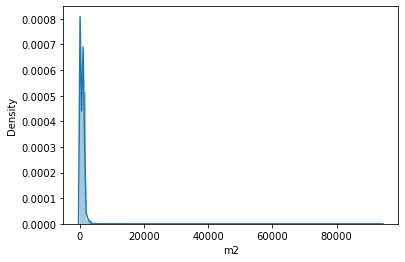

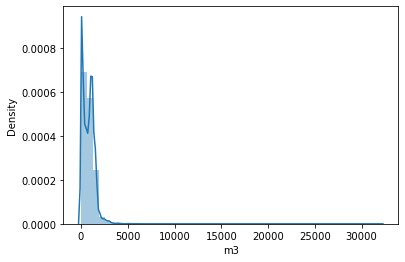

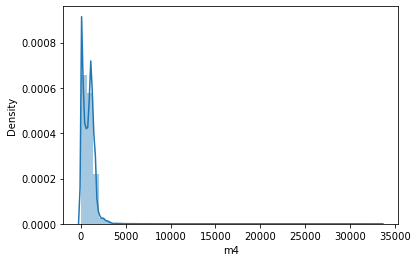

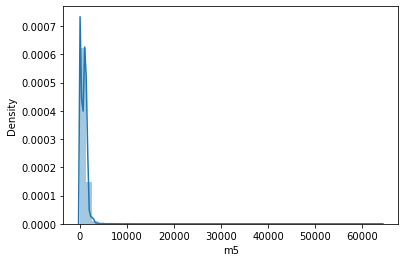

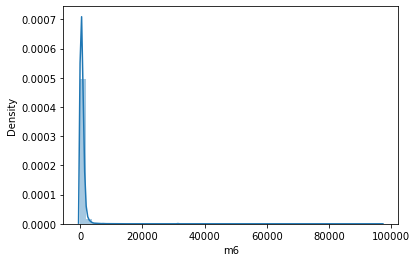

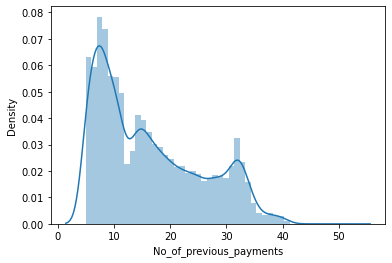

In [25]:
for col in train.columns[-6:]:
    
    plt.figure()
    #plt.subplot(2,2,i)
    sns.distplot(train[col])
    #print(col)

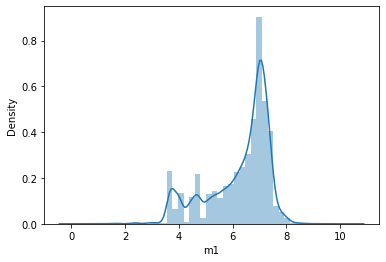

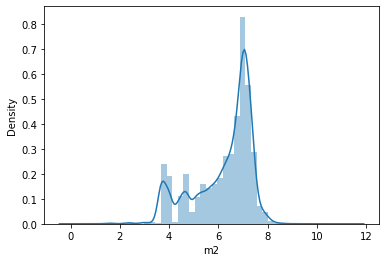

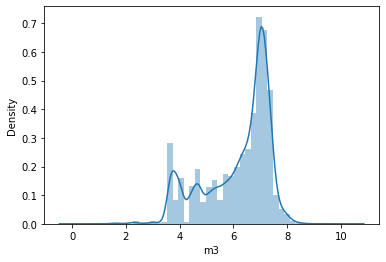

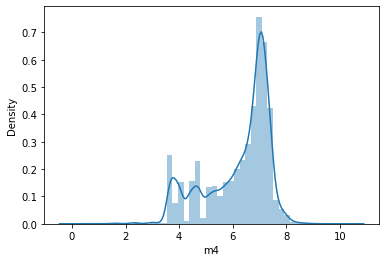

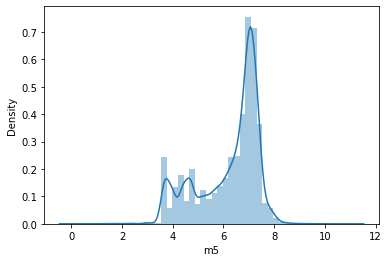

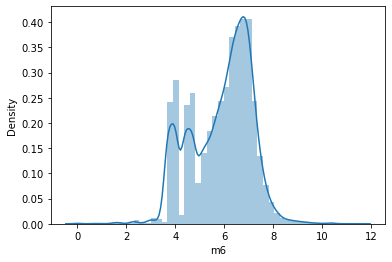

In [151]:
# Since the targets are greatly skewed we apply log transformaton

for target in train.columns[-6:]:
    train[target] = train[target].apply(np.log)

for col in train.columns[-6:]:
    plt.figure()
    sns.distplot(train[col])

<AxesSubplot:>

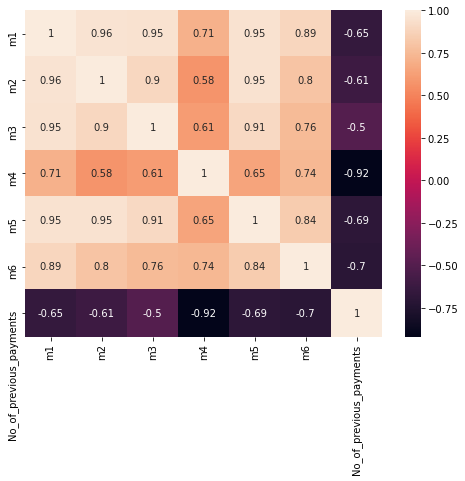

In [26]:
plt.figure(figsize=(8,6))
sns.heatmap(train.iloc[-6:].corr(), annot=True)

### Preprocessing

In [27]:
merged_ = preprocess_data(dff=merged, skip_cols=["PaymentsHistory", "TransactionDates"])

Processing datetime columns 	: 100%|█████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]
Checking for no of missing and dropping empty-like columns: 100%|█████████████████████| 27/27 [00:00<00:00, 122.17it/s]


The following columns have been dropped ['UpsellDate']


In [21]:
merged_.isna().sum()

ID                                   0
RegistrationDate                     0
Deposit                              0
AccessoryRate                        0
RatePerUnit                          0
DaysOnDeposit                        0
Age                                  0
Town                                 0
Term                                 0
TotalContractValue                   0
ExpectedTermDate                     0
FirstPaymentDate                     0
TransactionDates                     0
PaymentsHistory                      0
LastPaymentDate                      0
m1                                   0
m2                                   0
m3                                   0
m4                                   0
m5                                   0
m6                                   0
No_of_previous_payments              0
Target                               0
rateTypeEntity_MONTHLY               0
rateTypeEntity_WEEKLY                0
MainApplicantGender_Male 

### Features extraction

In [28]:
merged_ = extract_features(df=merged_)
merged_.head(n=5)

,ID,RegistrationDate,Deposit,AccessoryRate,RatePerUnit,DaysOnDeposit,Age,Town,Term,TotalContractValue,...,Occupation_Farmer,Occupation_Government Employee,Occupation_Labourer,Occupation_Other,Occupation_Teacher,RegisteredInLeapYear,RegisteredAtMonthStart,RegisteredAtMonthEnd,LastPaymentMonth,FirstPaymentMonth
0,ID_K00S4N4,2015-12-10,2000,0.0,35,7,41.0,5,364,14740.0,...,0,0,0,1,0,0.0,0.0,0.0,4,12
1,ID_6L67PAA,2015-12-09,2000,0.0,35,7,33.0,13,364,14740.0,...,0,0,0,1,0,0.0,0.0,0.0,7,12
2,ID_102CV85,2015-12-18,2000,35.0,35,7,48.0,22,392,29480.0,...,0,0,0,0,0,0.0,0.0,0.0,8,12
3,ID_HXBJFHB,2015-11-25,2000,0.0,35,7,43.0,43,364,14740.0,...,0,0,0,0,1,0.0,0.0,0.0,10,11
4,ID_3K9VZ5J,2015-12-02,2000,0.0,35,7,56.0,14,364,14740.0,...,0,0,0,1,0,0.0,0.0,0.0,11,12


In [29]:
# getting rows on metadata that corressponds to the test data base on ID
test_indx = [row[0] for row in merged_[['ID']].iterrows() if row[1]['ID'] in test['ID'].values]

In [30]:
test_indx[:10]

[1, 5, 8, 9, 12, 15, 25, 30, 36, 37]

In [25]:
merged_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37343 entries, 0 to 37342
Data columns (total 35 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   ID                                 37343 non-null  object        
 1   RegistrationDate                   37343 non-null  datetime64[ns]
 2   Deposit                            37343 non-null  int64         
 3   AccessoryRate                      37343 non-null  float64       
 4   RatePerUnit                        37343 non-null  int64         
 5   DaysOnDeposit                      37343 non-null  int64         
 6   Age                                37343 non-null  float64       
 7   Town                               37343 non-null  int8          
 8   Term                               37343 non-null  int64         
 9   TotalContractValue                 37343 non-null  float64       
 10  ExpectedTermDate                  

In [31]:
useless = [col for col in merged_.columns if merged_[col].nunique() == 1 or  merged_[col].nunique() == merged.shape[0]]
useless

['ID']

In [32]:
selected_features = [c for c in merged_.columns if "Date" not in c and c not in useless and c != 'Target']

# splitting the actual train set and test set
train_loan = merged_[selected_features].drop(test_indx)
status = merged_.Target.drop(test_indx)

# since there is no information on previous data about payment history on the test set then we will drop the target 
# created for it as it might be miss leading. It is much reasonable if we predict these from the train set
test_loan = merged_[selected_features].loc[test_indx]

## Split
"""xtrain_loan, xval_loan, ytrain_loan, yval_loan = train_test_split(
    xtrain_loan, 
    ytrain_loan, 
    test_size=.3, 
    random_state=21, 
    shuffle=True
)"""

scaler = StandardScaler()
##Fit scaler
scaler.fit(X=train_loan.values)

## Scale data
xtrain_loan = pd.DataFrame(scaler.transform(X=train_loan.values), columns=selected_features)
xtest_loan = pd.DataFrame(scaler.transform(X=test_loan.values), columns=selected_features)

print(f"> Training inputs shape : {xtrain_loan.shape}, Training targets shape : {status.shape}")
print(f"> Test inputs shape : {xtest_loan.shape}")

> Training inputs shape : (28007, 29), Training targets shape : (28007,)
> Test inputs shape : (9336, 29)


In [33]:
print('Column \t\tTrain \t\tTest\n')
for col in xtrain_loan.columns:
    print(col,'------------>',xtrain_loan[col].nunique(), end='----------->'); print(xtest_loan[col].nunique())

Column 		Train 		Test

Deposit ------------> 11----------->10
AccessoryRate ------------> 18----------->8
RatePerUnit ------------> 11----------->9
DaysOnDeposit ------------> 6----------->6
Age ------------> 80----------->75
Town ------------> 48----------->48
Term ------------> 46----------->28
TotalContractValue ------------> 30----------->22
No_of_previous_payments ------------> 39----------->37
rateTypeEntity_MONTHLY ------------> 2----------->2
rateTypeEntity_WEEKLY ------------> 2----------->2
MainApplicantGender_Male ------------> 2----------->2
Region_Mount Kenya Region ------------> 2----------->2
Region_Nairobi Region ------------> 2----------->2
Region_North Rift ------------> 2----------->2
Region_Nyanza ------------> 2----------->2
Region_South Rift ------------> 2----------->2
Region_Western ------------> 2----------->2
Occupation_Driver/Motorbike Rider ------------> 2----------->2
Occupation_Farmer ------------> 2----------->2
Occupation_Government Employee ------------

### Train/Val split

In [29]:
data.head()

,ID,TransactionDates,PaymentsHistory,LastPaymentDate,m1,m2,m3,m4,m5,m6,No_of_previous_payments
0,ID_MR53LEX,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[3600.0, 750.0, 350.0, 65.0, 95.0, 135.0, 85.0...",2020-11-01,880.0,930.0,495.0,715.0,220.0,385.0,31
1,ID_3D7NQUH,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[2940.0, 970.0, 380.0, 880.0, 385.0, 440.0, 11...",2020-11-01,660.0,935.0,935.0,825.0,770.0,935.0,30
2,ID_0IWQNPI,"['02-2020', '03-2020', '04-2020', '05-2020', '...","[2850.0, 1500.0, 1350.0, 610.0, 200.0, 250.0]",2020-07-01,700.0,1350.0,1550.0,1400.0,1450.0,1200.0,6
3,ID_IY8SYB9,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2200.0, 1420.0, 1180.0, 900.0, 1400.0, 780.0,...",2018-06-01,580.0,480.0,800.0,1260.0,1650.0,530.0,10
4,ID_9XHL7VZ,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2640.0, 910.0, 480.0, 280.0, 200.0, 180.0, 33...",2019-11-01,40.0,440.0,460.0,360.0,80.0,330.0,22


In [37]:
df.insert(0,'ID',data.ID)

In [45]:
df_m = pd.merge(df,metadata[['ID','Age','TotalContractValue','Term','Deposit']], on='ID')

In [38]:
df.index = df.ID

In [39]:
df.drop('ID', axis=1, inplace=True)

In [40]:
train_df = df.loc[train.ID,:]
test_df = df.loc[test.ID,:]

In [41]:
train_df.shape, test_df.shape

((28007, 61), (9336, 61))

In [44]:
train

,ID,TransactionDates,PaymentsHistory,LastPaymentDate,m1,m2,m3,m4,m5,m6,No_of_previous_payments
0,ID_MR53LEX,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[3600.0, 750.0, 350.0, 65.0, 95.0, 135.0, 85.0...",2020-11-01,880.0,930.0,495.0,715.0,220.0,385.0,31
1,ID_3D7NQUH,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[2940.0, 970.0, 380.0, 880.0, 385.0, 440.0, 11...",2020-11-01,660.0,935.0,935.0,825.0,770.0,935.0,30
2,ID_0IWQNPI,"['02-2020', '03-2020', '04-2020', '05-2020', '...","[2850.0, 1500.0, 1350.0, 610.0, 200.0, 250.0]",2020-07-01,700.0,1350.0,1550.0,1400.0,1450.0,1200.0,6
3,ID_IY8SYB9,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2200.0, 1420.0, 1180.0, 900.0, 1400.0, 780.0,...",2018-06-01,580.0,480.0,800.0,1260.0,1650.0,530.0,10
4,ID_9XHL7VZ,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2640.0, 910.0, 480.0, 280.0, 200.0, 180.0, 33...",2019-11-01,40.0,440.0,460.0,360.0,80.0,330.0,22
...,...,...,...,...,...,...,...,...,...,...,...
28002,ID_CDZ24L9,"['03-2018', '04-2018', '05-2018', '06-2018', '...","[5235.0, 1270.0, 940.0, 1370.0, 2020.0, 1750.0...",2019-04-01,1640.0,1550.0,2045.0,850.0,1730.0,720.0,14
28003,ID_0XINELS,"['02-2020', '03-2020', '04-2020', '05-2020', '...","[2980.0, 1000.0, 450.0, 1050.0, 850.0, 1250.0,...",2020-09-01,900.0,950.0,650.0,750.0,1200.0,620.0,8
28004,ID_PAU9JJU,"['01-2020', '02-2020', '03-2020', '04-2020', '...","[2580.0, 1020.0, 540.0, 360.0, 200.0, 660.0, 1...",2020-09-01,680.0,460.0,799.0,1070.0,820.0,401.0,9
28005,ID_K866QHS,"['02-2018', '03-2018', '04-2018', '05-2018', '...","[2000.0, 1160.0, 1240.0, 1120.0, 1000.0, 1200....",2018-09-01,1300.0,1055.0,1200.0,1200.0,1080.0,800.0,8


In [43]:
assert train_df.shape[0] == train.shape[0]
assert test_df.shape[0] == test.shape[0]

mode = train_df['Age'].mode()[0]
train_df['Age'].fillna(mode, inplace=True)
test_df['Age'].fillna(mode, inplace=True)

In [45]:
from sklearn.preprocessing import StandardScaler
x_scaler = StandardScaler()
X = x_scaler.fit_transform(train_df)
X_t = x_scaler.transform(test_df)

y = train.iloc[:,-7:-1].values

In [63]:
y

array([[ 880.,  930.,  495.,  715.,  220.,  385.],
       [ 660.,  935.,  935.,  825.,  770.,  935.],
       [ 700., 1350., 1550., 1400., 1450., 1200.],
       ...,
       [ 680.,  460.,  799., 1070.,  820.,  401.],
       [1300., 1055., 1200., 1200., 1080.,  800.],
       [ 970., 1080.,  960.,  840., 1000.,  370.]])

df_train, max_len = pad_history(df=train, max_len=41)

xtrain = df_train.PaymentsHistory.values
ytrain = df_train[train.columns[-6:]].values


xs = x_scaler.fit_transform(np.array(xtrain.tolist()).reshape((xtrain.shape[0], max_len)))

ys = np.array(ytrain.tolist()).reshape((ytrain.shape[0], 6))

#train_ds = tf.data.Dataset.from_tensor_slices((xs, ys))

# prepare test set
df_test, max_len = pad_history(df=test, max_len=41)

xtest = df_test.PaymentsHistory.values
xtst = x_scaler.transform(np.array(xtest.tolist()).reshape((xtest.shape[0], max_len)))


xs_df = np.hstack((xs,train['No_of_previous_payments'].values.reshape(-1,1)))
xtst_df =  np.hstack((xtst,test['No_of_previous_payments'].values.reshape(-1,1)))

In [202]:
xs.shape,ys.shape, 

((28007, 41), (28007, 6))

Text(0.5, 0, 'm2')

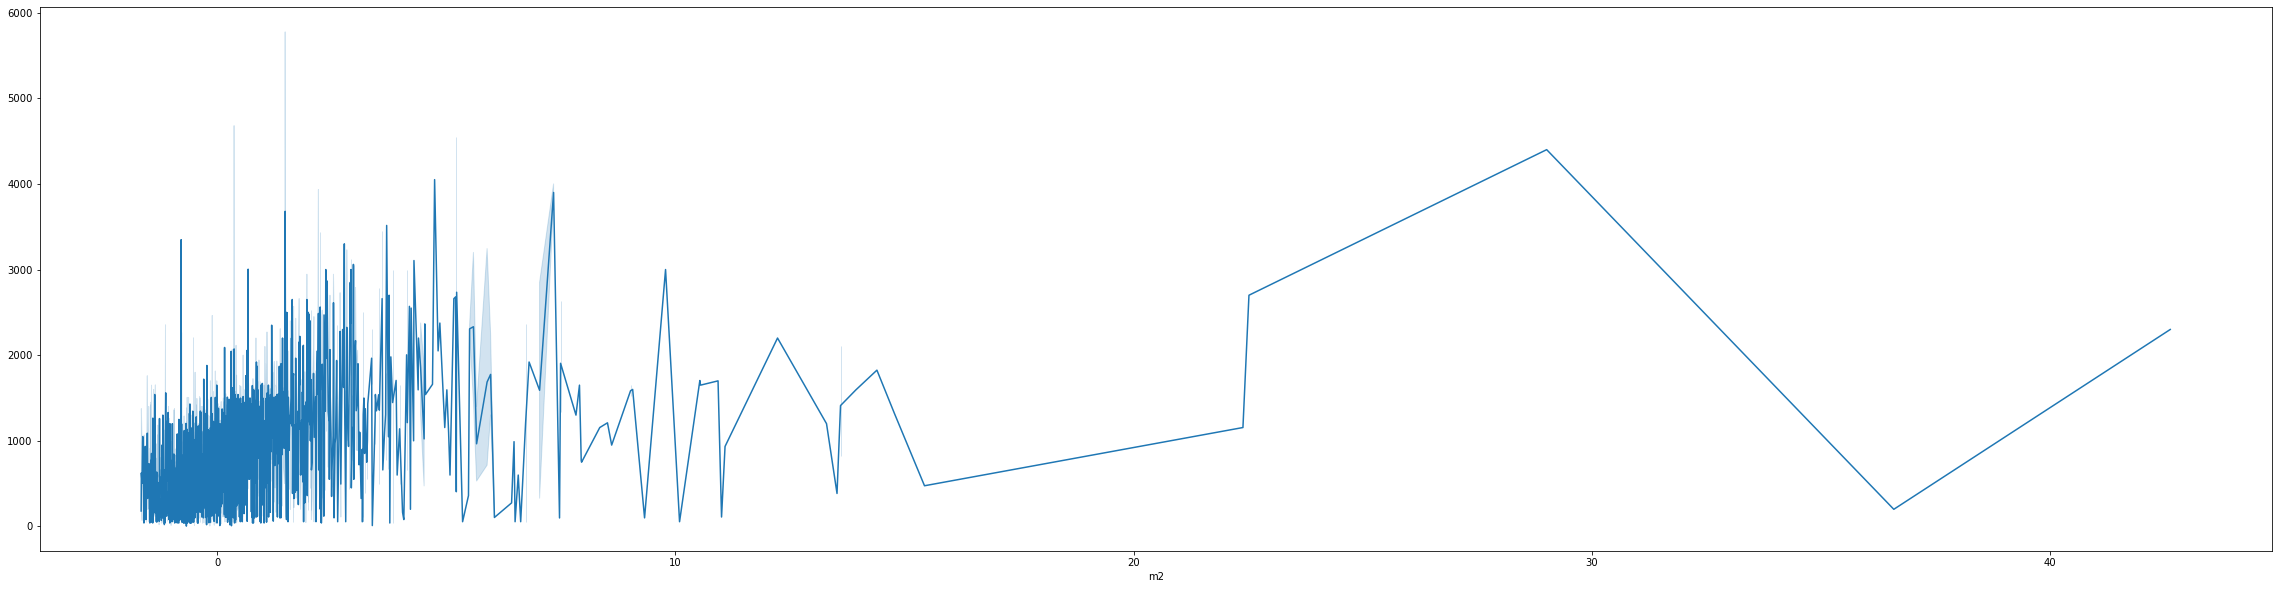

In [249]:
plt.figure(figsize=(40,10))
sns.lineplot(xs[:,1],ys[:,1])
plt.xlabel('m2')

## Modelling

In [64]:
X.shape, X_t.shape

((28007, 65), (9336, 65))

In [46]:
def build_model(out_shape=6):
    
    base_shape = xtrain_loan.shape[1]
    
    status_inp = keras.Input(shape=base_shape, name="status_inputs")
    x1 = keras.layers.Dense(base_shape, activation="sigmoid", name="x1")(status_inp)
    x11 = keras.layers.Dense(base_shape//2, activation="sigmoid", name="x11")(x1)
    x111 = Dropout(0.2)(x11)
    out1 = keras.layers.Dense(1, activation="sigmoid", name="out1")(x111)
    
    inp_shape = X.shape[1]
    payments_inp = keras.Input(shape=inp_shape, name="payments_inputs")
    x2 = keras.layers.Dense(66, activation="relu", name="x2")(payments_inp)
   # x22 = keras.layers.Dense(20, activation="relu", name="x22")(x2)
    x2_out = keras.layers.Dense(33, activation="relu", name="payment_out")(x2)
    
    concat = keras.layers.Concatenate(name="concat_layer")([out1, x2_out])
    out2 = keras.layers.Dense(out_shape, name="out2")(concat)
    
    # Model
    model = keras.Model(inputs=[payments_inp, status_inp], outputs=[out2,out1])
    
    opt = keras.optimizers.Adam(learning_rate=0.01)
    wgt = {"out1":.15, "out2":.85}
    
    model.compile(
        loss="mean_squared_error",
        optimizer=opt,
        loss_weights=wgt
    )

    #model.summary()
    
    return model


def build_payment_model(inp_shape=61):
    # Model
    
    payments_inp = inp_shape
    model = Sequential()
    model.add(Dense(inp_shape, input_dim=payments_inp, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(6))
    
    
    
    opt = keras.optimizers.Adam(learning_rate=0.01)
    
    model.compile(
        loss="mean_squared_error",
        optimizer=opt,
    )

   # model.summary()
    
    return model


def build_status_model():
    
    # Model
    status_inp = xtrain_loan.shape[1]
    model = Sequential()
    model.add(Dense(status_inp, input_dim=status_inp, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(status_inp//2, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    #x = keras.layers.Dense(20, activation="sigmoid", name="x2")(status_inp)
    #x_out = keras.layers.Dense(30, activation="sigmoid", name="statut_out")(x)
    
    #out = keras.layers.Dense(6, name="out")(x)
    
    
    #model = keras.Model(inputs=[status_inp], outputs=[out])
    
    opt = keras.optimizers.Adam(learning_rate=0.01)
    
    model.compile(
        loss="binary_crossentropy",
        optimizer=opt,
        metrics =['accuracy']
    )

    #model.summary()
    
    return model

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [56]:
model = KerasRegressor(build_fn= build_payment_model, batch_size=10, epochs=10,)
model.fit(X_train,y_train)

Epoch 1/10
1961/1961 [==============================] - 10s 5ms/step - loss: 645794.8750
Epoch 2/10
1961/1961 [==============================] - 11s 6ms/step - loss: 617270.3125 0s - - ETA: 0s - loss: 595
Epoch 3/10
1961/1961 [==============================] - 10s 5ms/step - loss: 614363.0000
Epoch 4/10
1961/1961 [==============================] - 8s 4ms/step - loss: 605246.6875
Epoch 5/10
1961/1961 [==============================] - 7s 4ms/step - loss: 600134.5625
Epoch 6/10
1961/1961 [==============================] - 8s 4ms/step - loss: 592676.6875
Epoch 7/10
1961/1961 [==============================] - 8s 4ms/step - loss: 590120.0000
Epoch 8/10
1961/1961 [==============================] - 7s 4ms/step - loss: 583925.2500
Epoch 9/10
1961/1961 [==============================] - 8s 4ms/step - loss: 580322.1250
Epoch 10/10
1961/1961 [==============================] - 7s 4ms/step - loss: 576074.3750


In [67]:
from scipy.stats import mode
def class_cv(model,X,y,test,random_state = 42,fold = 2):
    tot_val_pred = []
    tot_test_pred = np.zeros((fold,test.shape[0]))
    y_copy = y.copy()
    kf = KFold(n_splits=fold, random_state=random_state, shuffle=True)
    i = 0
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
       
        model.fit(X_train,y_train)
        y_pred =  model.predict(X_test)
        y_copy.iloc[test_index] = y_pred
        print(accuracy_score(y_pred,y_test))
        tot_test_pred[i] = model.predict(test)
        i += 1
    print('Val Accuracy', accuracy_score(y_copy,y))
    tot_test_pred = mode(tot_test_pred,axis = 0)[0][0]
    return y_copy,tot_test_pred
        

In [54]:
lgbm  = lightgbm.LGBMClassifier()
lgb_predictions = class_cv(lgbm,xtrain_loan,status,xtest_loan,fold=10)

0.7315244555515887
0.7297393787932881
0.7525883612995359
0.7454480542663334
0.741163870046412
0.7350946090681899
0.7475901463762942
0.7328571428571429
0.7171428571428572
0.7325
Val Accuracy 0.7365658585353662


In [50]:
len(log_predictions[0])

28007

In [84]:
from scipy.stats import mode
def reg_cv(base_model,X,y,test,random_state = 42,fold = 2, params=None, mult=None):
    tot_val_pred = []
    tot_test_pred = np.zeros((fold,test.shape[0],6))
    y_copy = y.copy()
    kf = KFold(n_splits=fold, random_state=random_state, shuffle=True)
    i = 0
    for train_index, test_index in tqdm(kf.split(X), desc='Kfold validation'):
        x_train, x_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        if mult != None:
            model = mult(base_model, params=params)
        else:
            model = base_model
        model.fit(x_train,y_train)
        y_pred =  model.predict(x_test)
        y_copy.iloc[test_index] = y_pred
        print(np.sqrt(mean_squared_error(y_pred,y_test)))
        tot_test_pred[i] = model.predict(test)
        i += 1
    print('RMSE:>', np.sqrt(mean_squared_error(y_copy,y)))
    tot_test_pred = mode(tot_test_pred,axis = 0)[0][0]
    return y_copy,tot_test_pred
        

In [28]:
from sklearn.base import RegressorMixin
class MultiEstimator_indepen(RegressorMixin):
    
    def __init__(self, model_object, params=None):
        """
        parametes to pass on to model_object instance
        estimator object to be instanciated
        """
        self.n_estim, self.lr = params
        
        self.model_object = model_object
        self.fitted_models = []
    
    def __repr__(self):
        return 'MultiEstimator(model_object = {}, n_fitted_models={})'.format(self.model_object, len(self.fitted_models))
    def fit(self,X,y):
        assert type(X) == pd.DataFrame
        assert type(y) == pd.DataFrame
        df = X.copy()
        self.n_train_cols = len(X.columns)
        self.col_names = y.columns
        """
        X : pd.DataFrame 
        y : pd.DataFrame or pd.Series
        """
        # getting number of coluns to predict
        n_cols = y.shape[1]
        for n_col in range(n_cols):
            # creating n instance of the model_object
            if self.n_estim != None:
                model = self.model_object(n_estimators=self.n_estim,learning_rate=self.lr )
            else:
                model = self.model_object()

            
            # making a single column as target at a time
            target = y.iloc[:,n_col]

            #saving each fitted instances of the model
            self.fitted_models.append(model.fit(df,target))

        return self
        
    def predict(self,X):
        """
        X : pd.DataFrame 
        """

        assert type(X) == pd.DataFrame
        assert self.n_train_cols == len(X.columns)

        df = X.copy()
        n_cols = len(self.fitted_models)
        preds_ = np.zeros((X.shape[0],n_cols))

        for n_col in range(n_cols):
            # retrieving the fitted models
            estimator = self.fitted_models[n_col]

            preds_[:,n_col] = estimator.predict(df)
            
        return preds_


In [77]:
from sklearn.base import RegressorMixin
class MultiEstimator(RegressorMixin):
    
    def __init__(self, model_object, params=None):
        """
        parametes to pass on to model_object instance
        estimator object to be instanciated
        """
        self.n_estim, self.lr = params
        
        self.model_object = model_object
        self.fitted_models = []
    
    def __repr__(self):
        return 'MultiEstimator(model_object = {}, n_fitted_models={})'.format(self.model_object, len(self.fitted_models))
    def fit(self,X,y):
        assert type(X) == pd.DataFrame
        assert type(y) == pd.DataFrame
        df = X.copy()
        self.n_train_cols = len(X.columns)
        self.col_names = y.columns
        """
        X : pd.DataFrame 
        y : pd.DataFrame or pd.Series
        """
        # getting number of coluns to predict
        n_cols = y.shape[1]
        for n_col in range(n_cols):
            # creating n instance of the model_object
            if self.n_estim != None:
                model = self.model_object(n_estimators=self.n_estim,learning_rate=self.lr )
            else:
                model = self.model_object()

            if n_col == 0:
                # making a single column as target at a time
                target = y.iloc[:,n_col]

                #saving each fitted instances of the model
                self.fitted_models.append(model.fit(df,target))

            elif n_col > 0:
                # adding previous cols to new learning set
                df1 = pd.concat([df,y.iloc[:,:n_col]], axis=1)
                target = y.iloc[:,n_col]

                self.fitted_models.append(model.fit(df1,target))

        return self
        
    def predict(self,X):
        """
        X : pd.DataFrame 
        """

        assert type(X) == pd.DataFrame
        assert self.n_train_cols == len(X.columns)

        df = X.copy()
        n_cols = len(self.fitted_models)
        preds_ = np.zeros((X.shape[0],n_cols))

        for n_col in range(n_cols):
            # retrieving the fitted models
            estimator = self.fitted_models[n_col]

            if n_col == 0:
                preds_[:,n_col] = estimator.predict(df)

            elif n_col > 0:
                temp_df = pd.DataFrame(preds_[:,:n_col], columns=self.col_names[:n_col])
                
                temp_df.index = df.index
                
                df1 = pd.concat([df,temp_df], axis=1)
                preds_[:,n_col] = estimator.predict(df1)

        return preds_


In [235]:
xs_df = pd.DataFrame(xs_df)
ys_df = pd.DataFrame(ys, columns=train.columns[-6:])

xtst_df = pd.DataFrame(xtst_df)

In [162]:
df_train.shape, df_test.shape, ys_df.shape

((28007, 70), (9336, 70), (28007, 6))

In [113]:
ys_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28007 entries, 0 to 28006
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   m1      28007 non-null  float64
 1   m2      28007 non-null  float64
 2   m3      28007 non-null  float64
 3   m4      28007 non-null  float64
 4   m5      28007 non-null  float64
 5   m6      28007 non-null  float64
dtypes: float64(6)
memory usage: 1.3 MB


In [114]:
X_train, X_test, Y_train, Y_test = train_test_split(xs_df,ys_df, test_size=0.2, random_state=42)

In [227]:
keras_model = KerasRegressor(build_fn=build_payment_model, batch_size=10, epochs=10, verbose=0)
preds = reg_cv(keras_model, xs_df,ys_df,xtst_df, fold=10,)

Kfold validation: 0it [00:00, ?it/s]

578.3281560663162


Kfold validation: 1it [00:59, 59.23s/it]

1130.8051326665723


Kfold validation: 2it [02:28, 77.14s/it]

662.3067562154241


Kfold validation: 3it [04:20, 92.85s/it]

688.0475477987465


Kfold validation: 4it [06:09, 99.09s/it]

767.0980933454637


Kfold validation: 5it [07:49, 99.41s/it]

851.0155449301175


Kfold validation: 6it [09:34, 101.43s/it]

687.420994821139


Kfold validation: 7it [11:28, 105.52s/it]

611.3584647877308


Kfold validation: 8it [13:23, 108.49s/it]

927.7533593219497


Kfold validation: 9it [15:05, 106.51s/it]

529.6894583594684


Kfold validation: 10it [16:54, 101.48s/it]


RMSE:> 763.2560106929722


In [49]:
X_df = pd.DataFrame(X, columns=train_df.columns)
y_df = pd.DataFrame(y)
X_t_df = pd.DataFrame(X_t, columns=test_df.columns)

In [91]:
base_estim = lightgbm.LGBMRegressor
preds = reg_cv(base_estim, X_df,y_df,X_t_df,mult = MultiEstimator, fold=10, params=(100, 0.1))

Kfold validation: 0it [00:00, ?it/s]

564.9537187330957


Kfold validation: 1it [00:15, 15.75s/it]

1136.6025627048023


Kfold validation: 2it [00:31, 16.00s/it]

693.4335596571735


Kfold validation: 3it [00:48, 16.24s/it]

750.0165218633


Kfold validation: 4it [01:04, 16.29s/it]

778.8299810130569


Kfold validation: 5it [01:20, 16.21s/it]

882.221915782142


Kfold validation: 6it [01:36, 16.13s/it]

720.7257407495401


Kfold validation: 7it [01:52, 15.86s/it]

684.5397475067334


Kfold validation: 8it [02:06, 15.35s/it]

959.9741310757821


Kfold validation: 9it [02:21, 15.17s/it]

577.8672044121378


Kfold validation: 10it [02:36, 15.69s/it]


RMSE:> 792.646398115623


In [51]:
def rmse(y_true,y_preds):
    return np.sqrt(mean_squared_error(y_true,y_preds))

In [52]:
def binary(x):
    if x >= 0.5:
        return 1
    else:
        return 0

In [53]:
model = build_model()

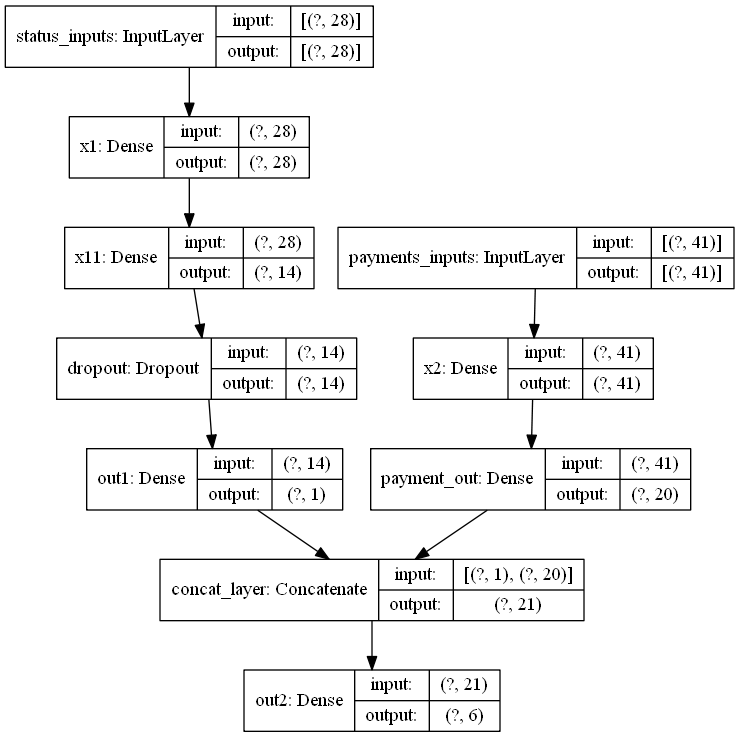

In [25]:
tf.keras.utils.plot_model(
        model,
        to_file="model.png", 
        show_shapes=True
    )

## Learning phase

## Eval/Inference time

In [54]:
X.shape,xtrain_loan.shape, y.shape, status.shape

((28007, 61), (28007, 29), (28007, 6), (28007,))

Using KFold

In [55]:

def cross_val_predict(test= [X_t,xtest_loan], b_size=10, epochs=20, splits= 5, output_dim=6):
    #data = pd.concat([xs,xtrain_loan])
    #target = pd.concat([ys,status])
    kf = KFold(n_splits=splits, shuffle=True, random_state=42)
    n = output_dim
    train_scores = []
    val_scores = []
    preds = np.zeros((splits,X_t.shape[0],n))
                     
    for idx, indexes in enumerate(tqdm(kf.split(X,y))):
        
        tr_idx, vl_idx  = indexes   
        # get all train sets
        xs_train, ys_train = X[tr_idx], y[tr_idx]
        x_train_loan, status_train = xtrain_loan.loc[tr_idx], status.values[tr_idx]
        
        #get all validation set
        xs_test, ys_test = X[vl_idx], y[vl_idx]
        x_test_loan, status_test = xtrain_loan.loc[vl_idx], status.values[vl_idx]
        
        # Build the Model
        estimator = build_model(out_shape=n)
        estimator.fit([xs_train,x_train_loan],[ys_train,status_train], batch_size=b_size, epochs=epochs, verbose=0)
        
        # predict on train set
        tr_preds = estimator.predict([xs_train,x_train_loan])
        out1_tr = tr_preds[1] # first output
        out1_tr = [binary(num) for num in out1_tr]
        out2_tr = tr_preds[0] # second putput
        
        # predicting on val set
        vl_preds = estimator.predict([xs_test,x_test_loan])
        out1_vl = vl_preds[1] # first output
        out1_vl = [binary(num) for num in out1_vl]
        out2_vl = vl_preds[0] # second output
        
        # predict on test: we only return the second output predictions as that is what is relevant to us
        preds[idx] = estimator.predict([X_t,xtest_loan])[0]
        
        # get scores : train
        out1_tr_score = accuracy_score(status_train,out1_tr)
        out2_tr_score = mean_squared_error(ys_train,out2_tr)
        
        # get scores : val
        out1_vl_score = accuracy_score(status_test,out1_vl)
        out2_vl_score = mean_squared_error(ys_test,out2_vl)
        
        train_scores.append((np.sqrt(out2_tr_score),out1_tr_score))
        val_scores.append((np.sqrt(out2_vl_score),out1_vl_score))
        
        print('(Out1)>>>ACC:> Train: %.3f    Val: %.3f' % (out1_tr_score*100,out1_vl_score*100))
        print('(Out2)>>>MSE:> Train: %.3f    Val: %.3f' % (np.sqrt(out2_tr_score),np.sqrt(out2_vl_score)))
        
    train_scores = np.array(train_scores)
    val_scores = np.array(val_scores)
    output1 = '(Out1)>>>ACC:> AvgTrain: %.3f +/- %.3f    AvgVal: %.3f +/- %.3f'
    output2 = '(Out2)>>>MSE:> AvgTrain: %.3f +/- %.3f    AvgVal: %.3f +/- %.3f'
    
    print(output1 % (np.mean(train_scores[:,1])*100,np.std(train_scores[:,1])*100,np.mean(val_scores[:,1])*100,np.std(val_scores[:,1])*100))
    print(output2 % (np.mean(train_scores[:,0]),np.std(train_scores[:,0]),np.mean(val_scores[:,0]),np.std(val_scores[:,0])))
    avg_preds = preds.mean(axis=0)
    
    assert avg_preds.shape[0] == X_t.shape[0], f"Shape mismatch, {avg_preds.shape[0]} predictions found while test set has {xtst.shape[0]} rows"
    
    return avg_preds

In [56]:
nn_preds = cross_val_predict(splits=10, epochs=20)

1it [05:36, 336.28s/it]

(Out1)>>>ACC:> Train: 55.138    Val: 55.480
(Out2)>>>MSE:> Train: 744.159    Val: 551.907


2it [10:39, 316.58s/it]

(Out1)>>>ACC:> Train: 54.634    Val: 54.873
(Out2)>>>MSE:> Train: 673.616    Val: 1146.861


3it [15:33, 306.36s/it]

(Out1)>>>ACC:> Train: 33.881    Val: 33.131
(Out2)>>>MSE:> Train: 731.997    Val: 700.028


4it [20:03, 292.12s/it]

(Out1)>>>ACC:> Train: 60.553    Val: 62.085
(Out2)>>>MSE:> Train: 730.991    Val: 762.640


5it [23:31, 261.83s/it]

(Out1)>>>ACC:> Train: 57.911    Val: 59.122
(Out2)>>>MSE:> Train: 740.949    Val: 792.801


6it [28:01, 264.44s/it]

(Out1)>>>ACC:> Train: 58.387    Val: 58.229
(Out2)>>>MSE:> Train: 734.187    Val: 877.629


7it [31:34, 247.65s/it]

(Out1)>>>ACC:> Train: 52.420    Val: 52.303
(Out2)>>>MSE:> Train: 730.690    Val: 704.257


8it [34:36, 226.78s/it]

(Out1)>>>ACC:> Train: 53.965    Val: 55.714
(Out2)>>>MSE:> Train: 733.241    Val: 697.872


9it [38:19, 225.71s/it]

(Out1)>>>ACC:> Train: 66.291    Val: 65.321
(Out2)>>>MSE:> Train: 712.361    Val: 1091.523


10it [41:19, 247.95s/it]

(Out1)>>>ACC:> Train: 52.335    Val: 51.821
(Out2)>>>MSE:> Train: 753.331    Val: 564.664
(Out1)>>>ACC:> AvgTrain: 54.551 +/- 7.983    AvgVal: 54.808 +/- 8.247
(Out2)>>>MSE:> AvgTrain: 728.552 +/- 20.899    AvgVal: 789.018 +/- 189.233


## Create submission

In [59]:
ss["Target"] = nn_preds.flatten()

In [60]:
ss.to_csv('submissions/submission_nn4.csv', index=False)

### some insights

1. !!! You must then build a machine learning model that returns the expected future payments for `n` months ahead !!! (Make sure one will be able to predict for more steps with your model and `set n=6 for this competition`)⚠️

2. Building a loan status predictor is highly recommended (likelihood of being a good/bad payer)✅

3. gradient boosting? random forest? reccurent net? even use an ensemble of many models. be creative 💡!

4. Cross validation ? why not 🤷🏾‍♂️

5. You can even try a Seq2Seq model : [resource](https://awaywithideas.com/keras-implementation-of-a-sequence-to-sequence-model-for-time-series-prediction-using-an-encoder-decoder-architecture/)